In [78]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from IPython import display

# Load layer configuration (DeltaE values by layer and beam type)
with open("../config/layers.yaml", "r") as f:
    layer_config = yaml.safe_load(f)

In [64]:
from scipy.optimize import curve_fit
def gaussian(x, A, mean, sigma):
    return A * np.exp(-(x - mean)**2 / (2 * sigma**2))

def fit_energy_spectrum(energies, bins=200, expand_window=False):
    counts, edges = np.histogram(energies, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2

    rms = np.std(energies)
    peak = centers[np.argmax(counts)]
    window = 2 * rms if expand_window else 1 * rms
    mask = (centers > peak - window) & (centers < peak + window)
    x_fit = centers[mask]
    y_fit = counts[mask]
    
    try:
        A0 = max(y_fit)
        sigma0 = rms
        popt, _ = curve_fit(
            gaussian,
            x_fit,
            y_fit,
            p0=[A0, peak, sigma0],
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf])  # force sigma > 0
        )
        A, mean, sigma = popt
        resolution = sigma / mean * 100
        return centers, counts, mean, sigma, resolution
    except Exception as e:
        print(f"Fit failed: {e}")
        return centers, counts, None, None, None

In [65]:
# Define run to beam mapping (each run corresponds to one beam type)
run_info = {
    "run0004": "350NT",
    "run0005": "350NT",
    "run0006": "350NT",
    "run0017": "500NT",
    "run0018": "500NT",
    "run0019": "withT",
    "run0020": "withT"
}

In [66]:
# Function to get expected DeltaE for a given row and beam
def get_expected_deltaE(layer_id, beam):
    layer_key = f"layer{int(layer_id)}"
    beam_key = f"DeltaE_{beam}"
    return layer_config[layer_key][beam_key]

In [67]:
# Example usage for one tile
run_id = "run0017"
beam = run_info[run_id]
layer_id = 4
x = 2
y = 0
data_path = f"../data/{run_id}/layer{layer_id}_x{x}_y{y}.csv"
df = pd.read_csv(data_path)

In [68]:
# Add layer info if not already present
df["layer"] = layer_id

# Assign label based on layer and beam
expected_deltaE = get_expected_deltaE(layer_id, beam)
df["label"] = expected_deltaE
print(f"Assigned expected DeltaE {expected_deltaE:.2f} for beam {beam} and layer {layer_id}")

Assigned expected DeltaE 323.40 for beam 500NT and layer 4


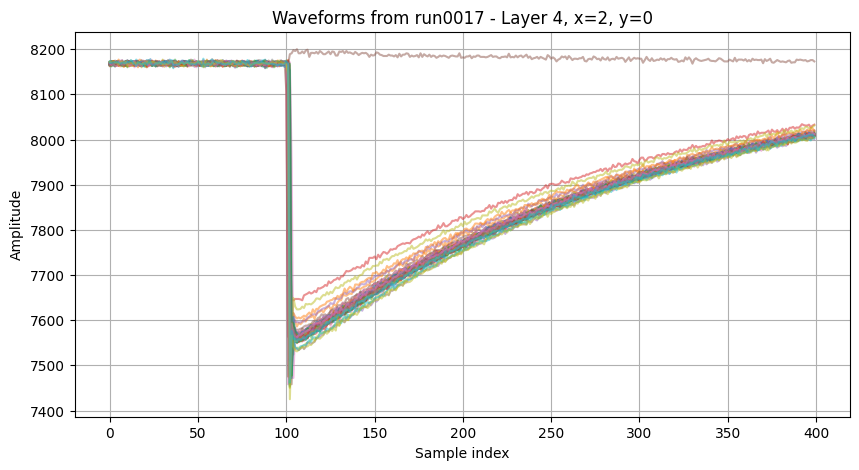

In [69]:
# Optional: plot waveforms
plt.figure(figsize=(10, 5))
for i in range(min(50, len(df))):
    wf = df[[c for c in df.columns if c.startswith("t")]].iloc[i].values
    plt.plot(wf, alpha=0.5)
plt.title(f"Waveforms from {run_id} - Layer {layer_id}, x={x}, y={y}")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [86]:
# --- Load waveform data for one pixel across 3 runs ---
runs = ["run0004", "run0017", "run0019"]
pixel_data = []
layer, xD, yD = 4, 2, 0

for run_id in runs:
    beam = run_info[run_id]
    label = layer_config[f"layer{layer}"][f"DeltaE_{beam}"]
    file = f"../data/{run_id}/layer{layer}_x{xD}_y{yD}.csv"
    df = pd.read_csv(file)
    df["label"] = label
    df["run"] = run_id
    df["beam"] = beam
    pixel_data.append(df)

df_all = pd.concat(pixel_data, ignore_index=True)

In [88]:
# --- Extract and preprocess features ---
X = df_all[[c for c in df_all.columns if c.startswith("t")]].values
X = X - np.mean(X[:, 20:80], axis=1, keepdims=True)
#X = X[:, 100:250]  # pulse window

y = df_all["label"].values
beam_labels = df_all["beam"].values

In [103]:
# --- Optional: Load MWD for comparison ---
mwd_energies = []
for run_id in runs:
    file = f"../output/MWD_{run_id}_layer{layer}_x{xD}_y{yD}.csv"
    mwd = pd.read_csv(file)["MWD_energy"].values
    mwd_energies.append(mwd)
y_mwd = np.concatenate(mwd_energies)
y_mwd_scaled = y_mwd * 3.8  # rough calibration to MeV

In [96]:
# --- Train/test split ---
X_train, X_test, y_train, y_test, beam_train, beam_test = train_test_split(
    X, y, beam_labels, test_size=0.2, random_state=42
)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [97]:
print(y_test[:20])

[402.86 323.4  402.86 377.64 323.4  377.64 402.86 377.64 323.4  323.4
 402.86 323.4  377.64 323.4  323.4  323.4  377.64 402.86 377.64 377.64]


In [98]:
# --- Dataset and dataloader ---
class WaveformDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = WaveformDataset(X_train, y_train)
test_ds = WaveformDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

In [99]:
# --- MLP Model ---
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X_train.shape[1])
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

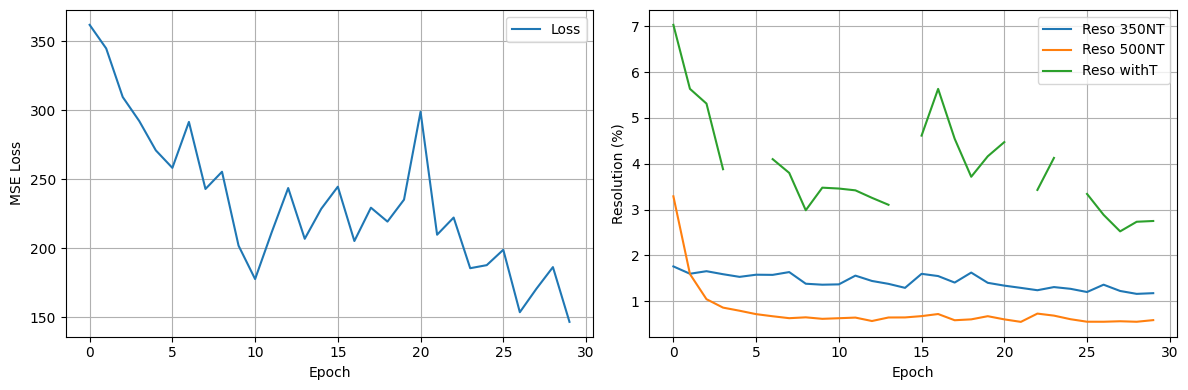

In [105]:
# --- Training loop with live loss + resolution ---
losses = []
resolutions_per_beam = {beam: [] for beam in np.unique(beam_labels)}
n_epochs = 30


for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xb)
    losses.append(total_loss / len(train_ds))

    # Evaluate per-beam resolution
    model.eval()
    y_pred = []
    with torch.no_grad():
        for xb, _ in test_loader:
            y_pred.extend(model(xb).squeeze().numpy())

    y_pred = np.array(y_pred)
    for beam in resolutions_per_beam:
        mask = (beam_test == beam)
        if np.sum(mask) > 10:
            res = fit_energy_spectrum(y_pred[mask])[-1]
            resolutions_per_beam[beam].append(res)
        else:
            resolutions_per_beam[beam].append(np.nan)

    # Live plot
    display.clear_output(wait=True)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label="Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
    plt.grid(True); plt.legend()

    plt.subplot(1, 2, 2)
    for beam in resolutions_per_beam:
        plt.plot(resolutions_per_beam[beam], label=f"Reso {beam}")
    plt.xlabel("Epoch"); plt.ylabel("Resolution (%)")
    plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.show()

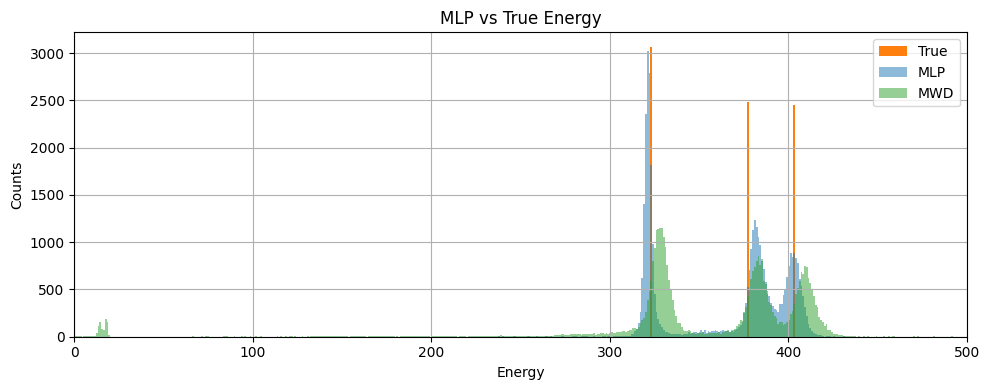

In [110]:
# --- Final evaluation ---

X_all = scaler.transform(X)
X_tensor = torch.tensor(X_all, dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_mlp_full = model(X_tensor).squeeze().numpy()
    
plt.figure(figsize=(10, 4))
bins = np.linspace(0,500,500)
plt.hist(y_true, bins=bins, alpha=1, label="True", color="C1")
bins = np.linspace(0,500,500)
plt.hist(y_mlp_full, bins=bins, alpha=0.5, label="MLP", color="C0")
plt.hist(y_mwd_scaled, bins=bins, alpha=0.5, label="MWD", color="C2")
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.xlim(0,500)
plt.title("MLP vs True Energy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [158]:
df_new = pd.read_csv("../data/run0153/layer4_x2_y0.csv")

In [166]:
X_new = df_new[[c for c in df_new.columns if c.startswith("t")]].values
X_new = X_new - np.mean(X_new[:, 20:80], axis=1, keepdims=True)
X_new = scaler.transform(X_new)  # use the same scaler as training

In [167]:
X_tensor = torch.tensor(X_new, dtype=torch.float32)
model.eval()
with torch.no_grad():
    y_pred_new = model(X_tensor).squeeze().numpy()


In [169]:
y_mwd_new = pd.read_csv("../output/MWD_run0153_layer4_x2_y0.csv")["MWD_energy"].values
y_mwd_new_scaled = y_mwd_new * 3.8


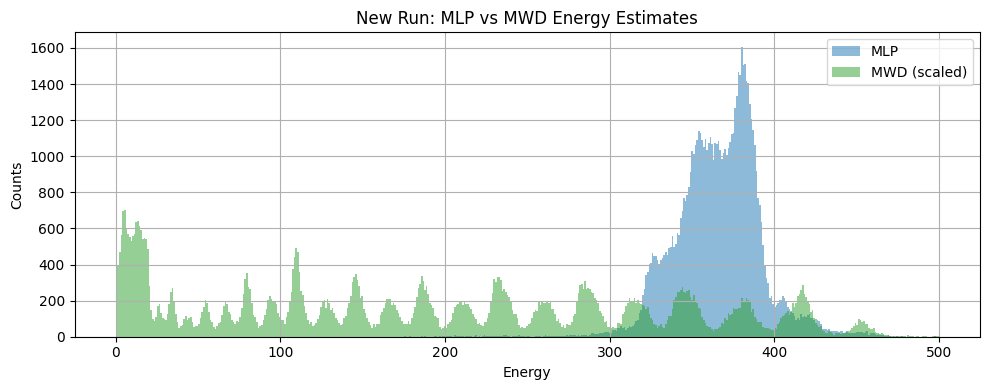

In [170]:
plt.figure(figsize=(10, 4))
bins = np.linspace(0, 500, 500)
plt.hist(y_pred_new, bins=bins, alpha=0.5, label="MLP", color="C0")
plt.hist(y_mwd_new_scaled, bins=bins, alpha=0.5, label="MWD (scaled)", color="C2")
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.title("New Run: MLP vs MWD Energy Estimates")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [184]:
mask = y_mwd_new * 3.8 > 350  # or < 400 to define a narrow gate
X_filtered = X_new[mask]
y_mwd_filtered = y_mwd_new[mask]


In [185]:
X_tensor = torch.tensor(X_filtered, dtype=torch.float32)
with torch.no_grad():
    y_pred_filtered = model(X_tensor).squeeze().numpy()

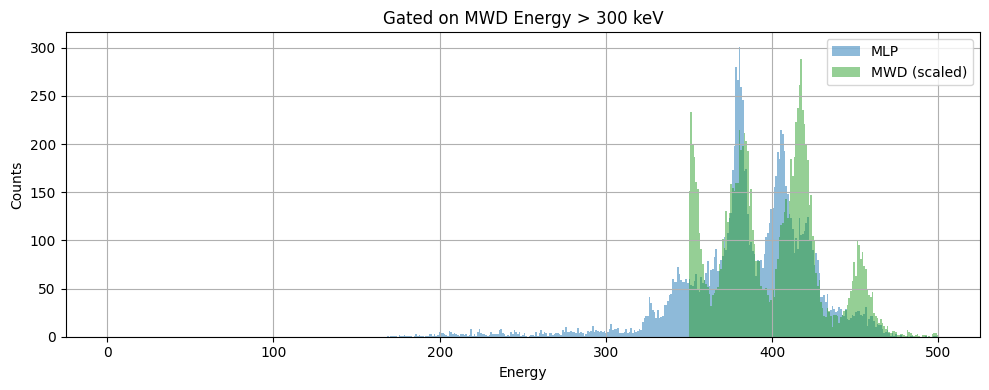

In [186]:
plt.figure(figsize=(10, 4))
bins = np.linspace(0, 500, 500)
plt.hist(y_pred_filtered, bins=bins, alpha=0.5, label="MLP", color="C0")
plt.hist(y_mwd_filtered * 3.8, bins=bins, alpha=0.5, label="MWD (scaled)", color="C2")
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.title("Gated on MWD Energy > 300 keV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
